In [1]:
#TODO manage the outliers
import pandas as pd
import math
import pandas as pd

In [2]:
#open the csv file of actors
actors = pd.read_csv('./data/actors.csv')

#open the csv file of awards
awards = pd.read_csv('./data/data_csv_awards.csv')

#open the movie tsv file
movies = pd.read_csv('./data/movie_summaries_ada/movie.metadata.tsv', sep='\t', header=None)
#define the columns
movies.columns = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']

#open the character.metadata.tsv file
characters = pd.read_csv('./data/movie_summaries_ada/character.metadata.tsv', sep='\t', header=None)
#define the columns of the character file
characters.columns = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birth',
                      'actor_gender','actor_height','actor_etnicity','actor_name','actor_age_at_release','freebase_char_actor_map_id','freebase_character_id','freebase_actor_id']

# Movies Dataset:

In [3]:
# there are 81741 rows
print("Original size: "+str(len(movies['wikipedia_id'])))
# check for duplicate wikipedia_id or name, every line is indeed unique but there are duplicates in the name column
print("Number of unique names: "+str(len(movies['name'].unique())))
print("Number of unique wiki ids: "+str(len(movies['wikipedia_id'].unique())))
# show an example of duplicated name, differ in the release date,and runtime
#print(movies[movies['name'] == 'The Bridge'])
# key identifier is the (name, release_date, runtime) tuple
# check for duplicates in the tuple
print("Number of unique tuples: "+str(len(movies.groupby(['name','release_date','runtime']))))
#show an example of duplicated tuple
#print(movies.groupby(['name','release_date','runtime']).size().sort_values(ascending=False).head(7))
#effective size is 81699 rows from now on
#record the duplicates names in a list
duplicates = movies[movies.duplicated(['name','release_date','runtime'])]
print("Number of duplicates: "+str(len(duplicates)))
#remove the duplicates keeping the row with the highest revenue
movies = movies.sort_values('revenue', ascending=False).drop_duplicates(['name','release_date','runtime']).sort_index()
print("New size without duplicates: "+str(len(movies['wikipedia_id'])))
# need to transform the release_date column to year because of IMBd dataset
movies['year_release'] = pd.to_datetime(movies["release_date"], infer_datetime_format=True, errors="coerce").dt.year


Original size: 81741
Number of unique names: 75478
Number of unique wiki ids: 81741
Number of unique tuples: 81699
Number of duplicates: 42
New size without duplicates: 81699


C:\Users\timba\AppData\Local\Temp\ipykernel_12340\1969108339.py:21: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  movies['year_release'] = pd.to_datetime(movies["release_date"], infer_datetime_format=True, errors="coerce").dt.year


Percentage of NaNs in each column: 
wikipedia_id     0.000000
freebase_id      0.000000
name             0.000000
release_date     8.407692
revenue         89.717132
runtime         24.986842
languages        0.000000
countries        0.000000
genres           0.000000
year_release    51.815812
dtype: float64
Statistics for revenue: 
count    8.401000e+03
mean     4.799363e+07
std      1.121753e+08
min      1.000000e+04
25%      2.083193e+06
50%      1.063969e+07
75%      4.071696e+07
max      2.782275e+09
Name: revenue, dtype: float64
Distribution of genres: 
genres
{"/m/07s9rl0": "Drama"}                                                                                                                                                                     6848
{}                                                                                                                                                                                          2288
{"/m/01z4y": "Comedy"}                  

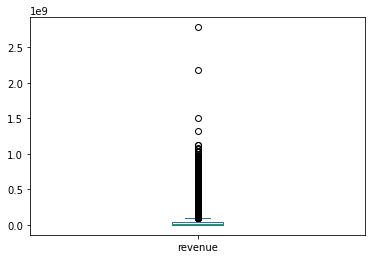

In [4]:
# check for outliers, percentage of NaNs in each column and distributions (min, max, mean, std)
# compute percentage of NaNs in each column # Lots of NaN in revenue to be very careful
print("Percentage of NaNs in each column: ")
print(movies.isnull().sum()/len(movies)*100)
# compute statistics for revenue
print("Statistics for revenue: ")
print(movies['revenue'].describe())
#plot the distribution of revenue with point cloud
movies['revenue'].plot(kind='box')

# compute the distribution of genres
print("Distribution of genres: ")
print(movies['genres'].value_counts())
# There is a lot of subcategories, probably need to group them. 2k NaNs and 6k Drama (3 times as much as next one)

In [5]:
# need to drop NaNs in the runtime, release year and name column in order to be able to correctly identify the movies
movies = movies.dropna(subset=['runtime','year_release','name'])

# runtime is int in IMBd dataset and float in the other one, need to convert it to int with a ceiling
movies['runtime'] = movies['runtime'].apply(lambda x: int(math.ceil(x)))
# transform the year_release column to int
movies['year_release'] = movies['year_release'].astype(int)

#print new size of movies (58k)
print("New size after dropping NaNs: "+str(len(movies['wikipedia_id'])))

New size after dropping NaNs: 32663


In [6]:
#load the heavy files aka titles imbd to find the imdb unique id, then use it to find the imdb rating and merge it with the movies dataframe
titles_imbd = pd.read_csv('./data/IMDB/title.basics.tsv', sep='\t')
# keep only the columns we need
titles_imbd = titles_imbd[['tconst','primaryTitle','startYear','runtimeMinutes']]

#load the imdb rating file
rating_imbd = pd.read_csv('./data/IMDB/title.ratings.tsv', sep='\t')

C:\Users\timba\AppData\Local\Temp\ipykernel_12340\4105059480.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles_imbd = pd.read_csv('./data/IMDB/title.basics.tsv', sep='\t')


In [7]:
#replacing the \N values with NaN
titles_imbd = titles_imbd.replace('\\N', pd.NA)
#drop the rows with NaN values
titles_imbd = titles_imbd.dropna()

# convert the startYear and runtimeMinutes column to numbers
titles_imbd['startYear'] = titles_imbd['startYear'].astype(int)
titles_imbd['runtimeMinutes'] = titles_imbd['runtimeMinutes'].astype(int)

# drop duplicates from the titles_imbd dataframe if the tuple (primaryTitle, startYear, runtimeMinutes) is duplicated
titles_imbd = titles_imbd.sort_values('runtimeMinutes', ascending=False).drop_duplicates(['primaryTitle','startYear','runtimeMinutes']).sort_index()

# merge the ratings_imbd dataframe with the titles_imbd dataframe
titles_imbd = titles_imbd.merge(rating_imbd, on='tconst')

# show size of the dataframe
print("Size of titles_imbd: "+str(len(titles_imbd['tconst'])))

Size of titles_imbd: 954198


In [8]:
# merge the movies dataframe with the titles_imbd dataframe
movies = movies.merge(titles_imbd, left_on=['name','year_release','runtime'], right_on=['primaryTitle','startYear','runtimeMinutes'], how='left')
#drop the useless columns
movies = movies.drop(columns=['primaryTitle','startYear','runtimeMinutes','tconst'])

# show new size of movies after merging with imdb
print("New size after merging with imdb: "+str(len(movies['wikipedia_id'])))

# 44.4% of the movies have a rating
print(str(movies.averageRating.count())+' movies have a rating over '+str(movies.name.count())+' movies, so '+str(round(movies.averageRating.count()*100/movies.name.count()))+' % movies do have a rating')

# we drop all the movies that don't have a rating because it is our dependent variable
movies = movies.dropna(subset=['averageRating'])

# show new size of movies after dropping movies without rating (25k)
print("New size after dropping movies without rating: "+str(len(movies['wikipedia_id'])))
# show size of the dataframe
print(movies.shape)

New size after merging with imdb: 32663
15106 movies have a rating over 32663 movies, so 46 % movies do have a rating
New size after dropping movies without rating: 15106
(15106, 12)


# Actors Dataset:

In [9]:
#filter the awards dataframe to only keep the rows with winner as True
#awards_winners = awards[awards.winner == True]

#filter the awards dataframe to only keep the rows with category containing ACTOR or ACTRESS
awards_actors = awards[awards.category.str.contains('ACTOR|ACTRESS')]
#awards_winners[awards_winners.category.str.contains('ACTOR|ACTRESS')]

#count the number of awards per entity in awards_actors
awards_actors_count = awards_actors.groupby('entity',as_index=False).count()

In [10]:
# get a list of unique actors from the character dataframe
actors_list = pd.DataFrame(characters.actor_name.unique())
print(actors_list.shape)

#rename the column
actors_list.columns = ['name']

#add a column to the actors_list dataframe with the winners count
actors_list = actors_list.merge(awards_actors_count[['entity','winner']], left_on='name', right_on='entity', how='left')
#drop the entity column
actors_list = actors_list.drop(columns=['entity'])
#rename the count column
actors_list = actors_list.rename(columns={'winner': 'awards'})
#fill the NaN values in the awards column with 0
actors_list['awards'] = actors_list['awards'].fillna(0)
print(actors_list.shape)

#create a dataframe with the number of movies per actor
actors_movies_count = pd.DataFrame(characters.actor_name.value_counts())

#add a column to the actors_list dataframe with the movies count
actors_list = actors_list.merge(actors_movies_count, left_on='name', right_index=True, how='left')
#rename the count column
actors_list = actors_list.rename(columns={'actor_name': 'movies'})
print(actors_list.shape)

#replace the Actor column of actors dataframe by the same value but replace each _ by a space
actors['Actor'] = actors['Actor'].str.replace('_', ' ')

#add the actors dataframe to the actors_list dataframe on the Actor column and name column respectively
actors_list = actors_list.merge(actors, left_on='name', right_on='Actor', how='left')

#drop the Actor column
actors_list = actors_list.drop(columns=['Actor'])
print(actors_list.shape)
#print the number of actors with a Fame value
print(str(actors_list.Fame.count())+' actors have a Fame value over '+str(actors_list.name.count())+' actors, so '+str(round(actors_list.Fame.count()*100/actors_list.name.count()))+' % actors do have a Fame value')
#replace the NaN values in the Fame column by 0
actors_list['Fame'] = actors_list['Fame'].fillna(0)
#replace the NaN values in the Liked,Disliked,Neutral columns by 0
actors_list['Liked'] = actors_list['Liked'].fillna(0)
actors_list['Disliked'] = actors_list['Disliked'].fillna(0)
actors_list['Neutral'] = actors_list['Neutral'].fillna(0)

#TODO:issue to solve, we loose about 46 actors in the merge because the name has . or ' or -, and we replace every _ by a space
#TODO: possible solution, replace every . or ' or - by a space in the actors_list dataframe
#TODO: possible solution, replace every . or ' or - or space by a _ in the actors dataframe

(134079, 1)
(134079, 2)
(134079, 3)
(134079, 7)
1310 actors have a Fame value over 134078 actors, so 1 % actors do have a Fame value


In [11]:
#make a pandas dataframe of the characters dataframe with only the first row of each actor
actors_metadata = characters.drop_duplicates(subset=['actor_name'], keep='first')
#drop the columns that we don't need
actors_metadata = actors_metadata.drop(columns=['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'character_name','actor_age_at_release', 'freebase_char_actor_map_id', 'freebase_character_id'])
actors_metadata.head()

,actor_birth,actor_gender,actor_height,actor_etnicity,actor_name,freebase_actor_id
0,1958-08-26,F,1.620,NaN,Wanda De Jesus,/m/03wcfv7
1,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,/m/0346l4
2,1969-06-15,M,1.727,/m/0x67,Ice Cube,/m/01vw26l
3,1967-09-12,M,1.750,NaN,Jason Statham,/m/034hyc
4,1977-09-25,F,1.650,NaN,Clea DuVall,/m/01y9xg


In [12]:
actors_info = actors_metadata.merge(actors_list, left_on='actor_name', right_on='name', how='left')
actors_info = actors_info.drop(columns=['name'])
print(actors_info.shape)
print(actors_info.head())

(134079, 12)
  actor_birth actor_gender  actor_height actor_etnicity          actor_name  \
0  1958-08-26            F         1.620            NaN      Wanda De Jesus   
1  1974-08-15            F         1.780     /m/044038p  Natasha Henstridge   
2  1969-06-15            M         1.727        /m/0x67            Ice Cube   
3  1967-09-12            M         1.750            NaN       Jason Statham   
4  1977-09-25            F         1.650            NaN         Clea DuVall   

  freebase_actor_id  awards  count  Fame  Liked  Disliked  Neutral  
0        /m/03wcfv7     0.0    8.0   0.0    0.0       0.0      0.0  
1         /m/0346l4     0.0   23.0   0.0    0.0       0.0      0.0  
2        /m/01vw26l     0.0   33.0  93.0   57.0      11.0     25.0  
3         /m/034hyc     0.0   31.0  78.0   59.0       4.0     14.0  
4         /m/01y9xg     0.0   31.0   0.0    0.0       0.0      0.0  


In [13]:
# show the percentage of NaNs in each column of actors_info
print("Percentage of NaNs in each column: ")
print(actors_info.isnull().sum()/len(actors_info)*100)

Percentage of NaNs in each column: 
actor_birth          56.755346
actor_gender         28.192334
actor_height         90.464577
actor_etnicity       93.955056
actor_name            0.000746
freebase_actor_id     0.000746
awards                0.000000
count                 0.000746
Fame                  0.000000
Liked                 0.000000
Disliked              0.000000
Neutral               0.000000
dtype: float64


# Character Dataset:

In [14]:
# show initial size of character dataframe
print("Initial size of characters: "+str(characters.shape))
# merge additional info of the actors to the characters dataframe
characters = characters.merge(actors_list[['name','Fame','Liked','Disliked','Neutral']], left_on='actor_name', right_on='name', how='left')
characters = characters.drop(columns=['name'])
# show new size of characters dataframe
#print("New size of the dataset"+str(characters.shape))
# compute percentage of NaNs in each column
#print("Percentage of NaNs in each column: ")
#print(characters.isnull().sum()/len(characters)*100)
#etnicty at 76% missing and gender at 10% missing
#to re compute if we remove the movies we don't have the rating for

# filter out all the character rows which wikipedia_movie_id is not in the movies dataframe
characters = characters[characters.wikipedia_movie_id.isin(movies.wikipedia_id)]

# show new size of characters dataframe
print("New size of the dataset after removing not reviewed movies: "+str(characters.shape))

# compute percentage of NaNs in each column
print("Percentage of NaNs in each column: ")
print(characters.isnull().sum()/len(characters)*100)
characters.head()

Initial size of characters: (450669, 13)
New size of the dataset after removing not reviewed movies: (112688, 17)
Percentage of NaNs in each column: 
wikipedia_movie_id             0.000000
freebase_movie_id              0.000000
movie_release_date             0.000000
character_name                42.619445
actor_birth                   20.468905
actor_gender                   6.935965
actor_height                  60.703890
actor_etnicity                77.386235
actor_name                     0.228063
actor_age_at_release          29.151285
freebase_char_actor_map_id     0.000000
freebase_character_id         42.615895
freebase_actor_id              0.166832
Fame                           0.000000
Liked                          0.000000
Disliked                       0.000000
Neutral                        0.000000
dtype: float64


,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birth,actor_gender,actor_height,actor_etnicity,actor_name,actor_age_at_release,freebase_char_actor_map_id,freebase_character_id,freebase_actor_id,Fame,Liked,Disliked,Neutral
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,0.0,0.0,0.0,0.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,0.0,0.0,0.0,0.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,93.0,57.0,11.0,25.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,78.0,59.0,4.0,14.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,0.0,0.0,0.0,0.0


In [15]:
characters_award_experience = characters.copy()
# Keep only rows with award category containing ACTOR or ACTRESS (e.g. ACTOR WITH LEADING ROLE)
# and only those who actually won
award_actors = awards_actors[awards_actors.winner == True].copy()
print(award_actors.columns)

# Get cumulative award count per actor (awards won until (excluding) the current award)
award_actors['award_cumcount'] = award_actors.groupby('entity').cumcount()
print(award_actors.columns)

# Convert 'movie_release_date' to datetime for merging, using coerce for unparseable dates
# For rows where conversion failed (resulted in NaT), extract the year directly from the string (often just the year is given)
# Leaves rows with no data about movie_release_date as NaT
characters_award_experience['release_year'] = pd.to_datetime(characters['movie_release_date'], errors='coerce').dt.year
characters_award_experience['release_year'] = characters_award_experience['release_year'].fillna(characters_award_experience['movie_release_date'].str.extract(r'(\d{4})')[0].astype(float))

print(characters.columns)

# Merge the DataFrames
characters_award_experience = pd.merge(characters_award_experience, 
                     award_actors[['entity', 'year', 'award_cumcount']], 
                     left_on=['actor_name', 'release_year'], 
                     right_on=['entity', 'year'], 
                     how='left')

# After merging, 'award_cumcount' will have NaNs for characters whose actors have no awards
# We replace these NaNs with 0
characters_award_experience['award_cumcount'].fillna(0, inplace=True)

# Drop the extra 'entity' column
characters_award_experience.drop(columns=['entity', 'release_year'], inplace=True)
characters_award_experience.head()

Index(['year', 'category', 'winner', 'entity'], dtype='object')
Index(['year', 'category', 'winner', 'entity', 'award_cumcount'], dtype='object')
Index(['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date',
       'character_name', 'actor_birth', 'actor_gender', 'actor_height',
       'actor_etnicity', 'actor_name', 'actor_age_at_release',
       'freebase_char_actor_map_id', 'freebase_character_id',
       'freebase_actor_id', 'Fame', 'Liked', 'Disliked', 'Neutral'],
      dtype='object')


,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birth,actor_gender,actor_height,actor_etnicity,actor_name,actor_age_at_release,freebase_char_actor_map_id,freebase_character_id,freebase_actor_id,Fame,Liked,Disliked,Neutral,year,award_cumcount
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,0.0,0.0,0.0,0.0,NaN,0.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,0.0,0.0,0.0,0.0,NaN,0.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,93.0,57.0,11.0,25.0,NaN,0.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,78.0,59.0,4.0,14.0,NaN,0.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,0.0,0.0,0.0,0.0,NaN,0.0


In [16]:
# Add Movie Experience
# 1. Clean: Extract Movies from character based df into new df and drop duplicates
# 2. Calc cumcount per actor in this seperate df
# 3. Left Join seperate df onto original df!
# 4. Drop roles of movies we don't look at!

characters_movie_exp = characters_award_experience.copy()

# Drop characters with no unique identifier for an actor
characters_movie_exp = characters_movie_exp.dropna(subset=['freebase_actor_id'])

assert characters_movie_exp.freebase_actor_id.isna().sum() == 0, "Some actors don't have an id"
assert characters_movie_exp.freebase_movie_id.isna().sum() == 0, "Some movies don't have an id"

# Drop actors that played twice in the same movie
characters_movie_exp = characters_movie_exp.drop_duplicates(['freebase_movie_id', 'freebase_actor_id'])

#  Get cumulative movie count per actor (movies done until (excluding) the current movie) as a measure of prior experience
characters_movie_exp['movies_cumcount'] = characters_movie_exp.groupby(['freebase_actor_id']).cumcount()

characters_merged_exp = pd.merge(characters, characters_movie_exp[['freebase_movie_id', 'freebase_actor_id', 'movies_cumcount', 'award_cumcount']], on=['freebase_movie_id', 'freebase_actor_id'], how='left' )

# Ensure we have data about the same set of movies to ensure comparability of findings
characters_merged_exp = characters_merged_exp[characters_merged_exp['freebase_movie_id'].isin(movies.freebase_id)]
characters = characters_merged_exp.copy()
display(characters)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birth,actor_gender,actor_height,actor_etnicity,actor_name,actor_age_at_release,freebase_char_actor_map_id,freebase_character_id,freebase_actor_id,Fame,Liked,Disliked,Neutral,movies_cumcount,award_cumcount
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,0.0,0.0,0.0,0.0,0.0,0.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,0.0,0.0,0.0,0.0,0.0,0.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,93.0,57.0,11.0,25.0,0.0,0.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,78.0,59.0,4.0,14.0,0.0,0.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112683,30553937,/m/0g9ts5h,1998-03-07,Barbara,NaN,F,NaN,NaN,Leda Mulholland,NaN,/m/0jxtsvw,/m/0jxtsvz,/m/0gbyr6p,0.0,0.0,0.0,0.0,0.0,0.0
112684,30553937,/m/0g9ts5h,1998-03-07,Restaurant Manager,NaN,M,NaN,NaN,Randy Harris,NaN,/m/0jxtsx5,/m/0jxtsx8,/m/0jxtsxh,0.0,0.0,0.0,0.0,0.0,0.0
112685,30553937,/m/0g9ts5h,1998-03-07,Julia,1975-10-10,F,NaN,NaN,Natalie Ramsey,22.0,/m/0jxtsw7,/m/0jxtswb,/m/027dt0m,0.0,0.0,0.0,0.0,2.0,0.0
112686,9971909,/m/02pygw1,1972-09-22,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,0.0,0.0,0.0,0.0,1.0,0.0


## Update of actors dataset:

In [17]:
# filter out actors in actors_info that are not in the characters dataframe
actors_info_test = actors_info[actors_info.actor_name.isin(characters.actor_name)]
# show new size of actors_info dataframe
print("New size of the dataset after removing actors not in characters: "+str(actors_info_test.shape))

# compute percentage of NaNs in each column
print("Percentage of NaNs in each column: ")
print(actors_info_test.isnull().sum()/len(actors_info_test)*100)

New size of the dataset after removing actors not in characters: (51085, 12)
Percentage of NaNs in each column: 
actor_birth          39.665264
actor_gender         13.845552
actor_height         82.307918
actor_etnicity       89.493981
actor_name            0.001958
freebase_actor_id     0.001958
awards                0.000000
count                 0.001958
Fame                  0.000000
Liked                 0.000000
Disliked              0.000000
Neutral               0.000000
dtype: float64


## Update of Movies dataset:
Adding character info summarized per movie to complete the dataset

In [18]:
#TODO

In [19]:
# basic info of the data to see changes when cleaning
print(actors.info())
print(awards.info())
print(movies.info())
print(characters.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355 entries, 0 to 1354
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Actor     1355 non-null   object
 1   Fame      1355 non-null   int64 
 2   Liked     1355 non-null   int64 
 3   Disliked  1355 non-null   int64 
 4   Neutral   1355 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 53.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11058 entries, 0 to 11057
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   year      11058 non-null  int64 
 1   category  11058 non-null  object
 2   winner    11058 non-null  bool  
 3   entity    11058 non-null  object
dtypes: bool(1), int64(1), object(2)
memory usage: 270.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 15106 entries, 0 to 32661
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --